 Ilona Smith - 2471308
 Luca von Mayer - 2427051
 Tumi Jourdan - 2180153
 Tao Yuan - 2332155

In [2]:
import torch
import torchinfo
import torch.nn.functional as F
import wandb
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap
from sklearn import datasets, decomposition, model_selection
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

pd.options.display.max_columns = None
pd.options.display.max_rows = None

c:\Tumi\Other Subjects\IDVE\IDVE-Assignments\Assignment 3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.backends.cudnn.deterministic = True
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [4]:
df = pd.read_csv('nba_2022-23_stats.csv')


In [5]:
#see if column types match expected types
print(df.dtypes)


Unnamed: 0         int64
Player Name       object
Salary             int64
Position          object
Age                int64
Team              object
GP                 int64
GS                 int64
MP               float64
FG               float64
FGA              float64
FG%              float64
3P                object
3PA              float64
3P%              float64
2P               float64
2PA              float64
2P%              float64
eFG%             float64
FT               float64
FTA              float64
FT%              float64
ORB              float64
DRB              float64
TRB              float64
AST              float64
STL              float64
BLK              float64
TOV              float64
PF               float64
PTS              float64
Total Minutes      int64
PER              float64
TS%              float64
3PAr             float64
FTr              float64
ORB%             float64
DRB%             float64
TRB%             float64
AST%             float64


## Question 1

In [6]:
df_copy = df.copy()

#find row with non numeric value
mask = pd.to_numeric(df_copy['3P'], errors='coerce').isna()
#recalculate value based on the other two columns
df_copy.loc[mask, '3P'] = (df_copy.loc[mask, '3PA'] * df_copy.loc[mask, '3P%']).round(1)
df_copy['3P'] = pd.to_numeric(df_copy['3P'], errors='coerce')

#replace NaN values with 0
df_copy = df_copy.fillna(0)

print(df_copy.dtypes)


Unnamed: 0         int64
Player Name       object
Salary             int64
Position          object
Age                int64
Team              object
GP                 int64
GS                 int64
MP               float64
FG               float64
FGA              float64
FG%              float64
3P               float64
3PA              float64
3P%              float64
2P               float64
2PA              float64
2P%              float64
eFG%             float64
FT               float64
FTA              float64
FT%              float64
ORB              float64
DRB              float64
TRB              float64
AST              float64
STL              float64
BLK              float64
TOV              float64
PF               float64
PTS              float64
Total Minutes      int64
PER              float64
TS%              float64
3PAr             float64
FTr              float64
ORB%             float64
DRB%             float64
TRB%             float64
AST%             float64


# Question 2

## Dataset loader

In [7]:
class CSVDataset(Dataset):
	def __init__(self, data, categorical_columns=None, target_columns=None):
		self.data = data
		if(categorical_columns!=None):
			dummies = pd.get_dummies(self.data[categorical_columns], columns=categorical_columns)
			self.data = pd.concat([self.data, dummies], axis=1)
		
		if target_columns is None:
			self.target_columns = self.data.columns
		else:
			self.target_columns = target_columns
		print(data.shape)
		print(self.target_columns.shape)

		# Normalize the data
		self.scaler = MinMaxScaler()
		self.normalized_data = self.scaler.fit_transform(self.data[self.target_columns])
		print(self.normalized_data)

	def get_feature_name(self,index):
		return(self.target_columns[index])
	def __len__(self):
		return len(self.normalized_data)

	def __getitem__(self, idx):
		x = torch.FloatTensor(self.normalized_data[idx])
		return x


In [8]:
full_dataset = CSVDataset(df_copy, categorical_columns=None, target_columns=df_copy.columns[6:])
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

train_data, split = model_selection.train_test_split(full_dataset, test_size=0.2)
valid_data, test_data = model_selection.train_test_split(split, test_size=0.5)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


(467, 52)
(46,)
[[0.67073171 0.6746988  0.83928571 ... 0.24361949 0.45272969 0.77922078]
 [0.40243902 0.03614458 0.52040816 ... 0.23201856 0.33688415 0.18181818]
 [0.87804878 0.28915663 0.69642857 ... 0.23897912 0.35552597 0.32467532]
 ...
 [0.02439024 0.         0.43112245 ... 0.19953596 0.30625832 0.16883117]
 [0.         0.         0.84693878 ... 0.20881671 0.32623169 0.16883117]
 [0.         0.         1.         ... 0.28074246 0.27163782 0.16883117]]


## Autoencoder

In [9]:
class Autoencoder(nn.Module):
	def __init__(self, input_dim, encoded_dim):
		super(Autoencoder, self).__init__()
		
		# Encoder
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 32),
			nn.ReLU(),
			nn.Linear(32, 16),
			nn.ReLU(),
			nn.Linear(16, 8),
			nn.ReLU(),
			nn.Linear(8, encoded_dim),
			# nn.ReLU()
		)
		
		# Decoder
		self.decoder = nn.Sequential(
			nn.Linear(encoded_dim, 8),
			nn.ReLU(),
			nn.Linear(8, 16),
			nn.ReLU(),
			nn.Linear(16, 32),
			nn.ReLU(),
			nn.Linear(32, input_dim),
			nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


## Autoencoder + other dimensionality reduction methods

In [10]:
class Autoencoder_plus(nn.Module):
	def __init__(self, input_dim, encoded_dim):
		super(Autoencoder_plus, self).__init__()
		
		# Encoder
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 32),
			nn.ReLU(),
			nn.Linear(32, 16),
			nn.ReLU(),
			# nn.Linear(16, 8),
			# nn.ReLU(),
			nn.Linear(16, encoded_dim),
			# nn.ReLU()
		)
		
		# Decoder
		self.decoder = nn.Sequential(
			nn.Linear(encoded_dim, 16),
			nn.ReLU(),
			# nn.Linear(8, 16),
			# nn.ReLU(),
			nn.Linear(16, 32),
			nn.ReLU(),
			nn.Linear(32, input_dim),
			nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


## Variational Autoencoder

In [11]:
class VariationalAutoencoder(nn.Module):
	def __init__(self, input_dim, encoded_dim=2):
		super(VariationalAutoencoder, self).__init__()
		
		# Encoder
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 32),
			nn.ReLU(),
			nn.Linear(32, 16),
			nn.ReLU(),
			nn.Linear(16, 8),
			nn.ReLU()
		)

		self.fc_mu = nn.Linear(8, encoded_dim)
		self.fc_logvar = nn.Linear(8, encoded_dim)
		
		# Decoder
		self.decoder = nn.Sequential(
			nn.Linear(encoded_dim, 8),
			nn.ReLU(),
			nn.Linear(8, 16),
			nn.ReLU(),
			nn.Linear(16, 32),
			nn.ReLU(),
			nn.Linear(32, input_dim),
			nn.Sigmoid()
		)

	def encode(self, x):
		hidden = self.encoder(x)
		mu = self.fc_mu(hidden)
		logvar = self.fc_logvar(hidden)
		return mu, logvar

	def reparameterize(self, mu, log_var):
		# if self.training:
		std = torch.exp(0.5 * log_var)
		eps = torch.randn_like(std)
		return mu + eps * std
		# return mu

	def forward(self, x):
		mu, log_var = self.encode(x)
		z = self.reparameterize(mu, log_var)
		decoded = self.decoder(z)
		return decoded, mu, log_var

	def vae_loss(self, recon_x, x, mu, log_var):
		mse_loss = nn.MSELoss(reduction='mean')
		MSE = mse_loss(recon_x, x)
		KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
		
		return MSE + KLD


## Training Loop

In [12]:
input_dim = len(df_copy.columns[6:])
encoded_dim = 2
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(input_dim, encoded_dim).to(device)
wandb.init(project = "autoencoder")
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# torchinfo.summary(model, (1, input_dim), col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

for epoch in range(num_epochs):
	model.train()
	total_loss = 0
	
	for inputs in train_loader:
		inputs = inputs.to(device)

		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, inputs)
		loss.backward()
		optimizer.step()
		
		total_loss += loss.item()
	
	model.eval()
	total_val_loss = 0
	with torch.no_grad():
		for val_inputs in valid_loader:
			val_inputs = val_inputs.to(device)

			val_outputs = model(val_inputs)
			val_loss = criterion(val_outputs, val_inputs)
			total_val_loss += val_loss.item()
		
	total_val_loss /= len(valid_loader)
	total_loss /= len(train_loader)
	
	wandb.log({
		"epoch": epoch,
		"train_loss": total_loss,
		"val_loss": total_val_loss,
	})

	torch.save(model.state_dict(), 'autoencoder_model.pth')

	print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}, Validation Loss: {total_val_loss:.4f}')


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch [1/100], Train Loss: 0.0594, Validation Loss: 0.0353
Epoch [2/100], Train Loss: 0.0326, Validation Loss: 0.0323
Epoch [3/100], Train Loss: 0.0300, Validation Loss: 0.0305
Epoch [4/100], Train Loss: 0.0298, Validation Loss: 0.0309
Epoch [5/100], Train Loss: 0.0295, Validation Loss: 0.0301
Epoch [6/100], Train Loss: 0.0290, Validation Loss: 0.0276
Epoch [7/100], Train Loss: 0.0240, Validation Loss: 0.0211
Epoch [8/100], Train Loss: 0.0182, Validation Loss: 0.0142
Epoch [9/100], Train Loss: 0.0147, Validation Loss: 0.0130
Epoch [10/100], Train Loss: 0.0137, Validation Loss: 0.0121
Epoch [11/100], Train Loss: 0.0131, Validation Loss: 0.0119
Epoch [12/100], Train Loss: 0.0131, Validation Loss: 0.0116
Epoch [13/100], Train Loss: 0.0128, Validation Loss: 0.0114
Epoch [14/100], Train Loss: 0.0128, Validation Loss: 0.0115
Epoch [15/100], Train Loss: 0.0127, Validation Loss: 0.0113
Epoch [16/100], Train Loss: 0.0128, Validation Loss: 0.0113
Epoch [17/100], Train Loss: 0.0125, Validation Lo

### Auto Encoder Results


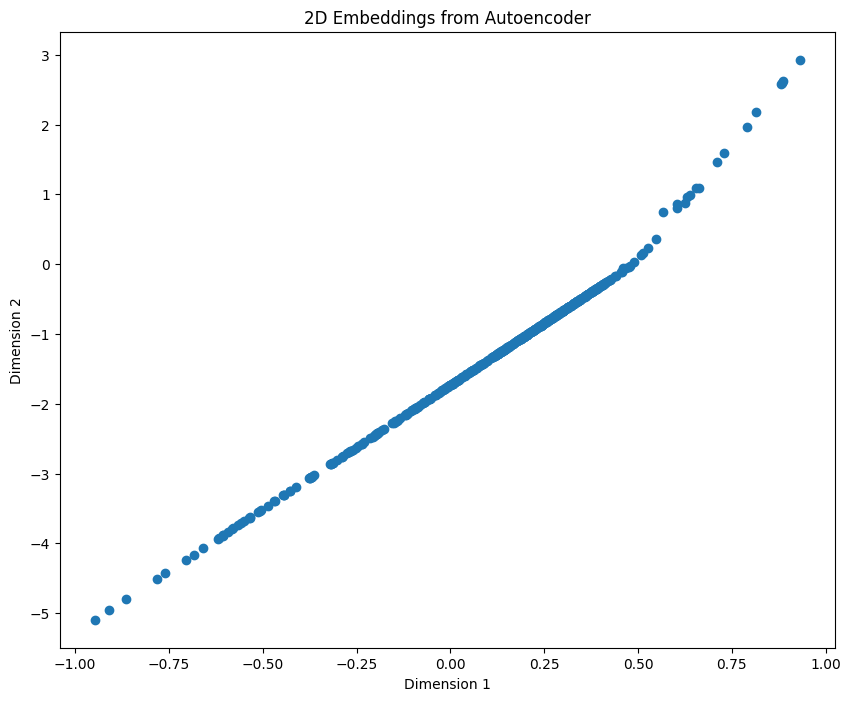

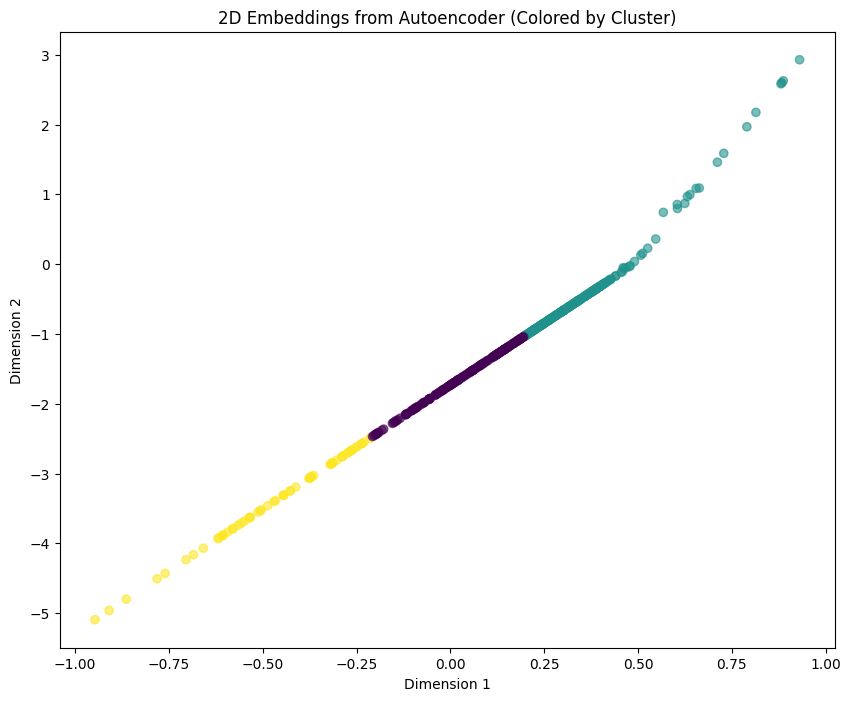

In [13]:
model.eval()
embeddings = []

print(full_loader.dataset)
with torch.no_grad():
	for inputs in full_loader:
		inputs = inputs.to(device)
		encoded_data = model.encoder(inputs)
		embeddings.append(encoded_data.cpu())

embeddings = torch.cat(embeddings, dim=0)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder (Colored by Cluster)')
plt.show()



In [23]:
import shap
class EncoderWrapper:
    def __init__(self, encoder, dimension):
        self.encoder = encoder
        self.dimension = dimension  # 0 or 1 for which encoded dimension to analyze
        
    def __call__(self, X):
        # Convert numpy array to torch tensor
        X_tensor = torch.FloatTensor(X).to(next(self.encoder.parameters()).device)
        with torch.no_grad():
            encoded = self.encoder(X_tensor)
        # Return the specified dimension
        return encoded[:, self.dimension].cpu().numpy()
    
wrapper_dim0 = EncoderWrapper(model.encoder, 0)
wrapper_dim1 = EncoderWrapper(model.encoder, 1)
# Step 2: Iterate through the DataLoader
original_data_list = []
with torch.no_grad():
    for inputs in full_loader:  # Assuming your DataLoader returns (inputs, targets)
        original_data_list.append(inputs.cpu())  # Move data to CPU if necessary

# Step 3: Concatenate the original data into a single tensor
original_data = torch.cat(original_data_list, dim=0)
# Create background data for SHAP
background_data = original_data.numpy()[:100]  # Using first 100 samples as background

# Initialize the SHAP explainer for each dimension
explainer_dim0 = shap.KernelExplainer(wrapper_dim0, background_data)
explainer_dim1 = shap.KernelExplainer(wrapper_dim1, background_data)

# Calculate SHAP values for a subset of data points
sample_data = original_data.numpy()[:50]  # Using first 50 samples for analysis
shap_values_dim0 = explainer_dim0.shap_values(sample_data)
shap_values_dim1 = explainer_dim1.shap_values(sample_data)

# Create feature names
feature_names = [f'Feature {full_dataset.get_feature_name(i)}' for i in range(original_data.shape[1])]

# Plot SHAP summary plots for both dimensions
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
shap.summary_plot(shap_values_dim0, sample_data, feature_names=feature_names, 
                 show=False, plot_size=(8, 12))
plt.title('Feature Importance for Dimension 1')

plt.subplot(1, 2, 2)
shap.summary_plot(shap_values_dim0, sample_data, feature_names=feature_names, 
                 show=False, plot_size=(8, 12))
plt.title('Feature Importance for Dimension 2')

plt.tight_layout()
plt.show()

# Calculate and print the top 10 most important features for each dimension
def get_top_features(shap_values, feature_names, n=10):
    importance = np.abs(shap_values).mean(0)
    feature_importance = list(zip(feature_names, importance))
    return sorted(feature_importance, key=lambda x: x[1], reverse=True)[:n]

print("\nTop 10 most important features for Dimension 1:")
top_features_dim0 = get_top_features(shap_values_dim0, feature_names)
for feature, importance in top_features_dim0:
    print(f"{feature}: {importance:.4f}")

print("\nTop 10 most important features for Dimension 2:")
top_features_dim1 = get_top_features(shap_values_dim1, feature_names)
for feature, importance in top_features_dim1:
    print(f"{feature}: {importance:.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]c:\Tumi\Other Subjects\IDVE\IDVE-Assignments\Assignment 3\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Tumi\Other Subjects\IDVE\IDVE-Assignments\Assignment 3\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  2%|▏         | 1/50 [00:00<00:40,  1.20it/s]c:\Tumi\Other Subjects\IDVE\IDVE-Assignments\Assignment 3\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Tumi\Other Subjects\IDVE\IDVE-Assignments\Assignment 3\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  4%

KeyboardInterrupt: 

In [15]:
input_dim = len(df_copy.columns[6:])
encoded_dim = 10
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder_plus(input_dim, encoded_dim).to(device)
wandb.init(project = "autoencoder", name='autoencoder_plus')
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# torchinfo.summary(model, (1, input_dim), col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

for epoch in range(num_epochs):
	model.train()
	total_loss = 0
	
	for inputs in train_loader:
		inputs = inputs.to(device)

		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, inputs)
		loss.backward()
		optimizer.step()
		
		total_loss += loss.item()
	
	model.eval()
	total_val_loss = 0
	with torch.no_grad():
		for val_inputs in valid_loader:
			val_inputs = val_inputs.to(device)

			val_outputs = model(val_inputs)
			val_loss = criterion(val_outputs, val_inputs)
			total_val_loss += val_loss.item()
		
	total_val_loss /= len(valid_loader)
	total_loss /= len(train_loader)
	
	wandb.log({
		"epoch": epoch,
		"train_loss": total_loss,
		"val_loss": total_val_loss,
	})

	torch.save(model.state_dict(), 'autoencoder_plus_model.pth')

	print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}, Validation Loss: {total_val_loss:.4f}')


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇██
train_loss,█▇▇▇▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_loss,0.01174
val_loss,0.01022


Epoch [1/10], Train Loss: 0.0665, Validation Loss: 0.0429
Epoch [2/10], Train Loss: 0.0339, Validation Loss: 0.0308
Epoch [3/10], Train Loss: 0.0270, Validation Loss: 0.0250
Epoch [4/10], Train Loss: 0.0231, Validation Loss: 0.0214
Epoch [5/10], Train Loss: 0.0197, Validation Loss: 0.0168
Epoch [6/10], Train Loss: 0.0160, Validation Loss: 0.0142
Epoch [7/10], Train Loss: 0.0144, Validation Loss: 0.0129
Epoch [8/10], Train Loss: 0.0139, Validation Loss: 0.0126
Epoch [9/10], Train Loss: 0.0137, Validation Loss: 0.0128
Epoch [10/10], Train Loss: 0.0136, Validation Loss: 0.0120


In [16]:
model.eval()
embeddings = []
with torch.no_grad():
	for inputs in full_loader:
		inputs = inputs.to(device)
		encoded_data = model.encoder(inputs)
		embeddings.append(encoded_data.cpu())

embeddings = torch.cat(embeddings, dim=0)


### TSNE Results


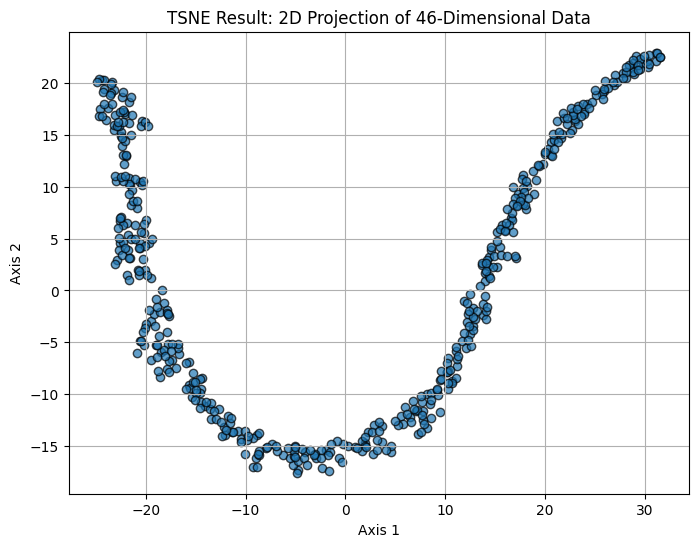

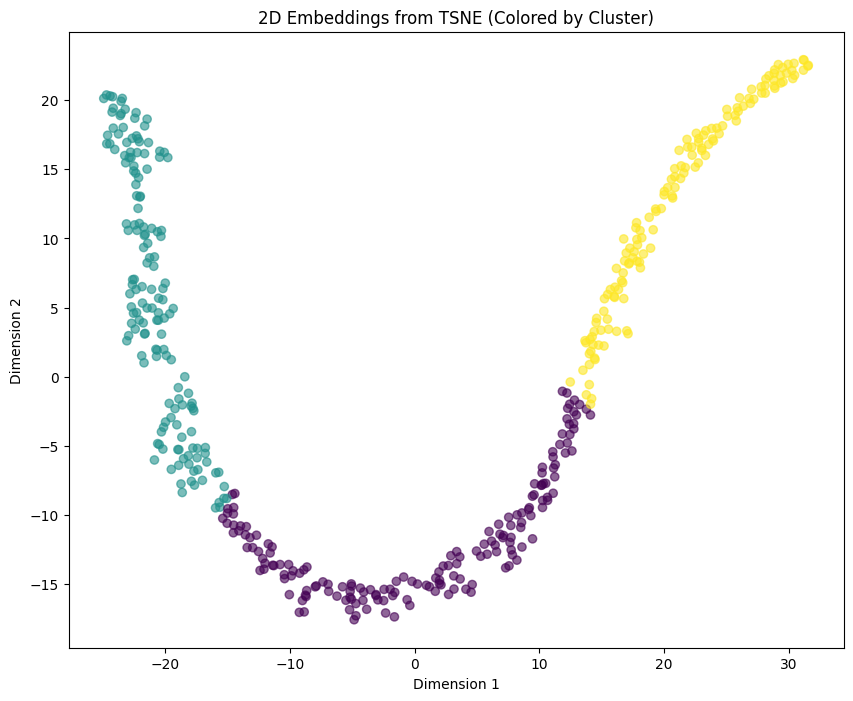

In [17]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, edgecolors='k')
plt.title('TSNE Result: 2D Projection of 46-Dimensional Data')
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.grid()
plt.show()




kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(tsne_result)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from TSNE (Colored by Cluster)')
plt.show()


### UMap Results

c:\Tumi\Other Subjects\IDVE\IDVE-Assignments\Assignment 3\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


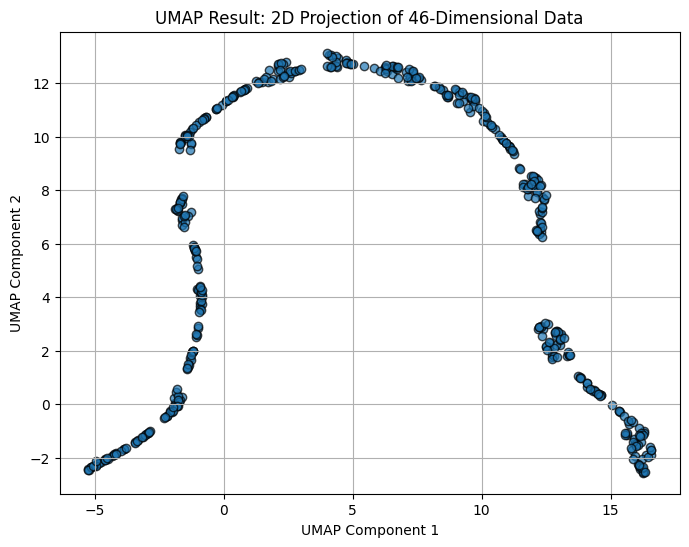

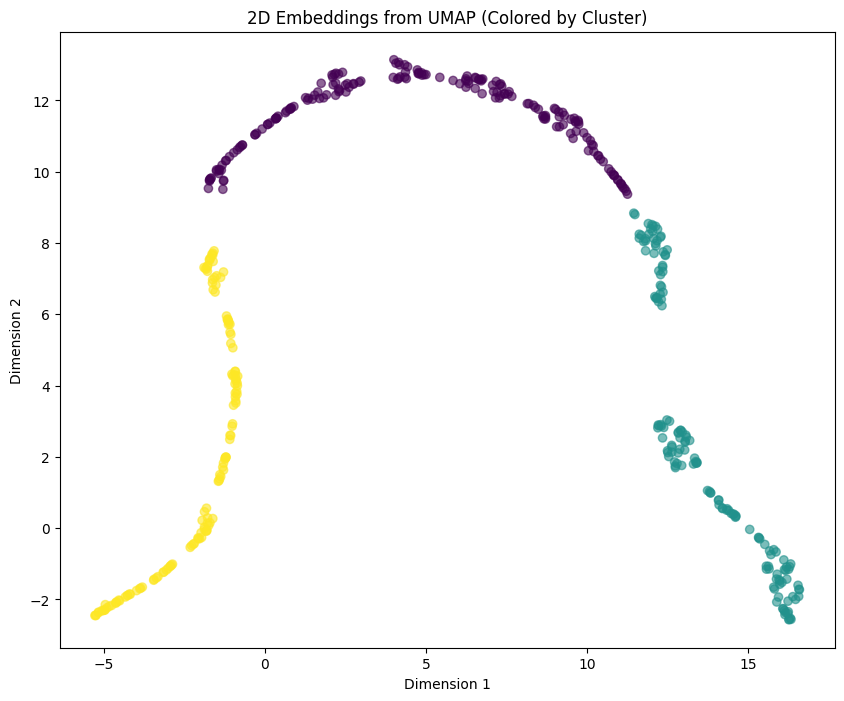

In [18]:
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.7, edgecolors='k')
plt.title('UMAP Result: 2D Projection of 46-Dimensional Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(umap_result)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from UMAP (Colored by Cluster)')
plt.show()


### SOMs Results

torch.Size([467, 10])
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.11420968463355835


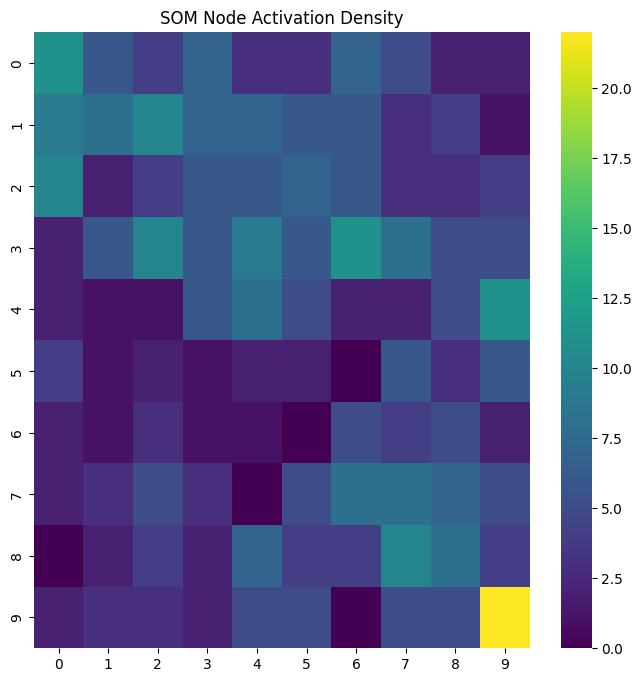

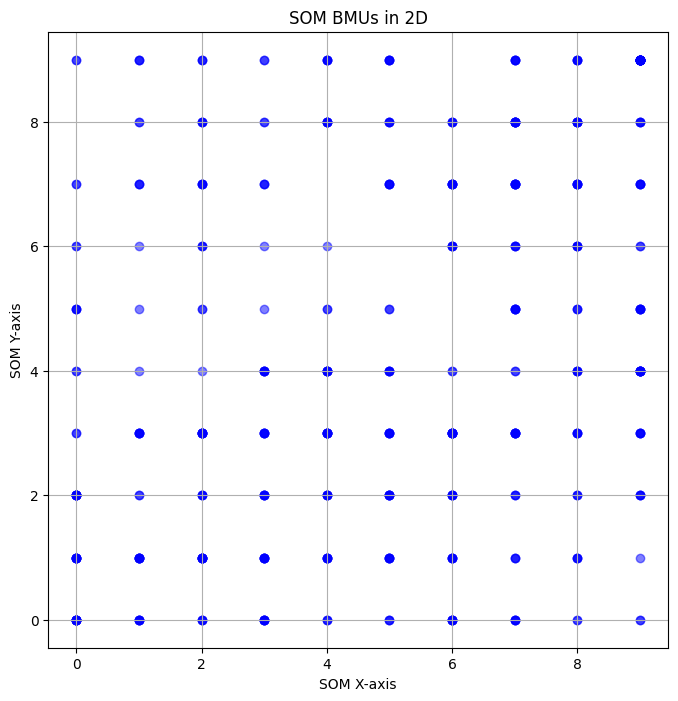

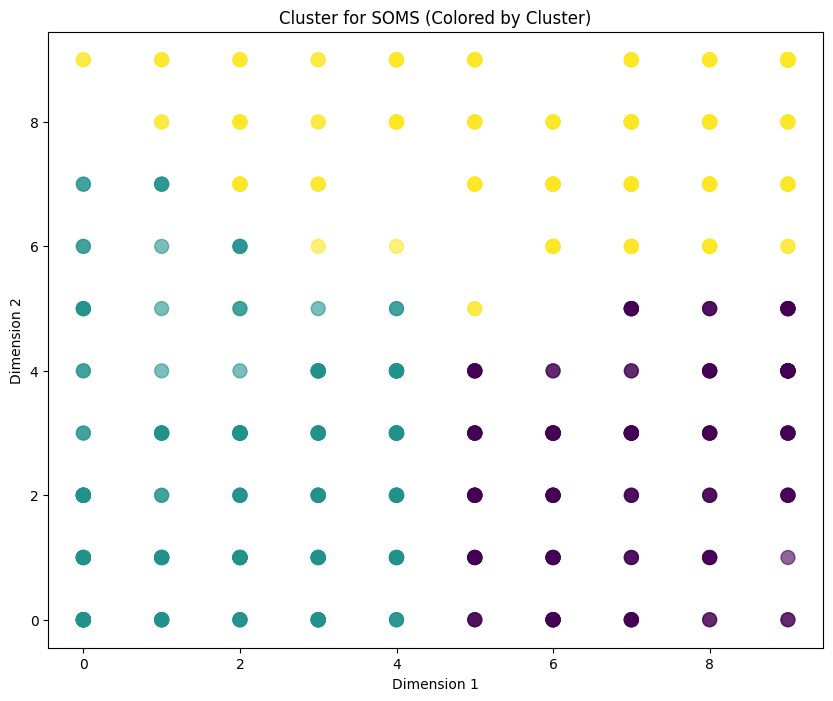

In [19]:
som = MiniSom(x=10,
			  y=10,
			  input_len=embeddings.shape[1],
			  sigma=10/4,
			  learning_rate=0.3,
			  neighborhood_function='gaussian',
			  random_seed=42)

print(embeddings.shape)

som.random_weights_init(embeddings)
som.train(embeddings, 1000, verbose=True)
bmus = np.array([som.winner(x) for x in embeddings])

heatmap = np.zeros((10, 10))
for x, y in bmus:
	heatmap[x, y] += 1

plt.figure(figsize=(8, 8))
sns.heatmap(heatmap.T, cmap='viridis')
plt.title('SOM Node Activation Density')
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(bmus[:, 0], bmus[:, 1], c='blue', alpha=0.5)
plt.title('SOM BMUs in 2D')
plt.xlabel('SOM X-axis')
plt.ylabel('SOM Y-axis')
plt.grid()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(bmus)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(bmus[:, 0], bmus[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=100)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Cluster for SOMS (Colored by Cluster)')
plt.show()


In [20]:
# each neuron represents a cluster
bmus = np.array([som.winner(x) for x in embeddings])


### Variational Autoencoder Results

In [21]:
input_dim = len(df_copy.columns[6:])
encoded_dim = 2
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VariationalAutoencoder(input_dim, encoded_dim).to(device)
wandb.init(project = "autoencoder", name='variational_autoencoder')
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

for epoch in range(num_epochs):
	model.train()
	total_loss = 0

	for inputs in train_loader:
		inputs = inputs.to(device)

		optimizer.zero_grad()
		outputs, mu, log_var = model(inputs)
		loss = model.vae_loss(outputs, inputs, mu, log_var)
		loss.backward()
		optimizer.step()

		total_loss += loss.item()
	
	model.eval()
	total_val_loss = 0
	with torch.no_grad():
		for val_inputs in valid_loader:
			val_inputs = val_inputs.to(device)

			val_outputs, val_mu, val_logvar = model(val_inputs)
			val_loss = model.vae_loss(val_outputs, val_inputs, val_mu, val_logvar)
			total_val_loss += val_loss.item()

	total_val_loss /= len(valid_loader)
	total_loss /= len(train_loader)

	wandb.log({
		"epoch": epoch,
		"train_loss": total_loss,
		"val_loss": total_val_loss,
	})

	torch.save(model.state_dict(), 'variational_autoencoder.pth')

	print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}')


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▁▁▁▁▁
val_loss,█▅▄▃▂▁▁▁▁▁
epoch,9
train_loss,0.01355
val_loss,0.01204


Epoch [1/10], Train Loss: 0.4813
Epoch [2/10], Train Loss: 0.0649
Epoch [3/10], Train Loss: 0.0394
Epoch [4/10], Train Loss: 0.0305
Epoch [5/10], Train Loss: 0.0302
Epoch [6/10], Train Loss: 0.0298
Epoch [7/10], Train Loss: 0.0297
Epoch [8/10], Train Loss: 0.0294
Epoch [9/10], Train Loss: 0.0294
Epoch [10/10], Train Loss: 0.0294


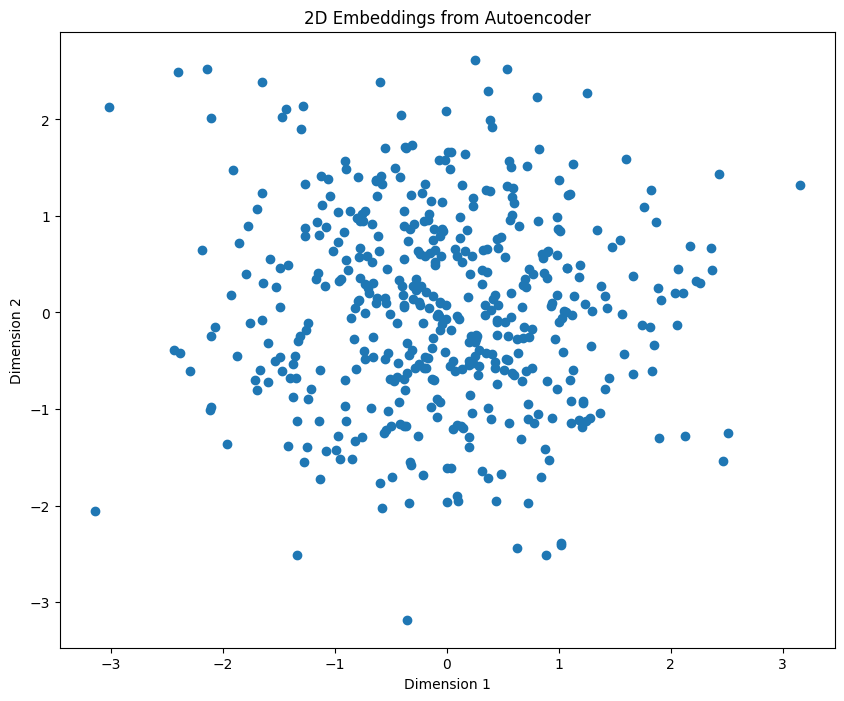

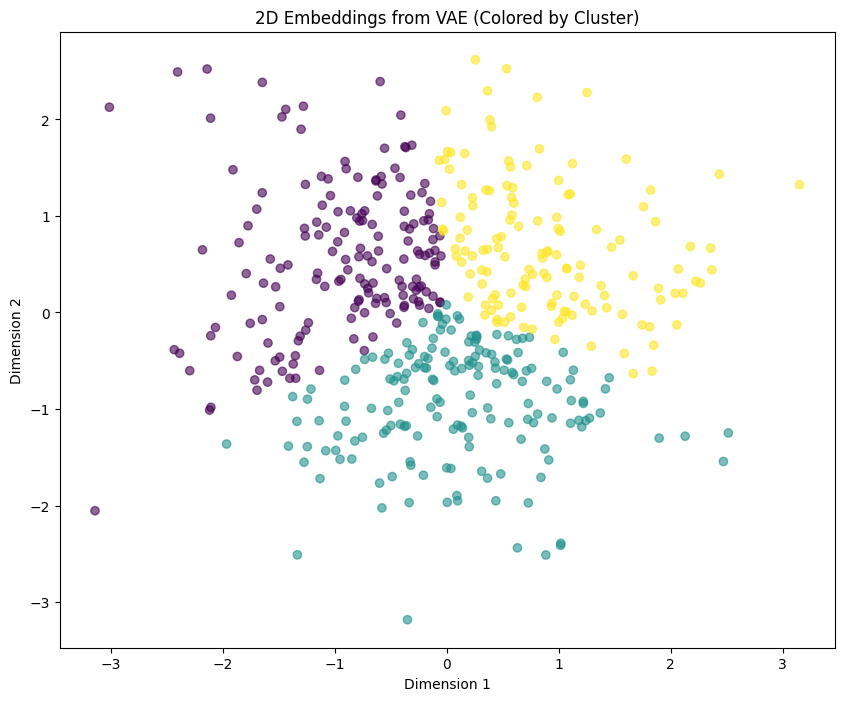

In [22]:
model.eval()
embeddings2 = []
with torch.no_grad():
	for inputs in full_loader:
		inputs = inputs.to(device)
		mu, log_var = model.encode(inputs)
		z = model.reparameterize(mu, log_var)
		embeddings2.append(z.cpu())

embeddings2 = torch.cat(embeddings2, dim=0)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings2[:, 0], embeddings2[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from Autoencoder')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings2[:, 0], embeddings2[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings from VAE (Colored by Cluster)')
plt.show()
